In [33]:
import pandas as pd
import numpy as np

In [34]:
data=pd.read_csv('Bone Tumor Dataset.csv')

In [35]:
data.head

<bound method NDFrame.head of     Patient ID     Sex  Age         Grade  \
0      STS_001  Female   63          High   
1      STS_002  Female   54  Intermediate   
2      STS_003    Male   22  Intermediate   
3      STS_004  Female   54  Intermediate   
4      STS_005    Male   63          High   
..         ...     ...  ...           ...   
495    STS_496    Male   31  Intermediate   
496    STS_497    Male   41          High   
497    STS_498  Female   60  Intermediate   
498    STS_499    Male   43          High   
499    STS_500  Female   73  Intermediate   

                              Histological type        MSKCC type  \
0                   pleiomorphic leiomyosarcoma    Leiomyosarcoma   
1                   pleiomorphic leiomyosarcoma               MFH   
2                              synovial sarcoma               MFH   
3                              synovial sarcoma    Leiomyosarcoma   
4    pleiomorphic spindle cell undifferentiated               MFH   
..             

In [36]:
data.columns


Index(['Patient ID', 'Sex', 'Age', 'Grade', 'Histological type', 'MSKCC type',
       'Site of primary STS', 'Status (NED, AWD, D)', 'Treatment'],
      dtype='object')

In [37]:
data['Grade'].unique()

array(['High', 'Intermediate'], dtype=object)

In [38]:
data['Histological type'].unique()

array(['pleiomorphic leiomyosarcoma', 'synovial sarcoma',
       'pleiomorphic spindle cell undifferentiated',
       'poorly differentiated synovial sarcoma', 'myxoid fibrosarcoma',
       'sclerosing epithelioid fibrosarcoma', 'leiomyosarcoma',
       'malignant solitary fibrous tumor',
       'undifferentiated pleomorphic liposarcoma', 'myxofibrosarcoma',
       'epithelioid sarcoma', 'undifferentiated - pleiomorphic',
       'pleomorphic sarcoma'], dtype=object)

In [39]:
data['MSKCC type'].unique()

array(['Leiomyosarcoma', 'MFH', 'Synovial sarcoma'], dtype=object)

In [40]:
data['Site of primary STS'].unique()

array(['parascapusular', 'left thigh', 'right buttock', 'right thigh',
       'right parascapusular', 'left biceps', 'left buttock'],
      dtype=object)

In [41]:
data['Status (NED, AWD, D)'].unique()

array(['NED', 'D', 'AWD'], dtype=object)

In [42]:
data['Treatment'].unique()

array(['Radiotherapy + Surgery', 'Surgery + Chemotherapy',
       'Radiotherapy + Surgery + Chemotherapy'], dtype=object)

In [43]:
%pip install tensorflow



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, LSTM, Reshape

In [45]:
data.drop('Patient ID', axis=1, inplace=True)


In [46]:
target = 'Status (NED, AWD, D)'
features = data.drop(columns=[target])
target_data = data[target]

In [47]:
categorical_cols = ['Sex', 'Grade', 'Histological type', 'MSKCC type', 'Site of primary STS', 'Treatment']
features = pd.get_dummies(features, columns=categorical_cols)

In [48]:

label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target_data)


In [49]:
scaler = StandardScaler()
features['Age'] = scaler.fit_transform(features[['Age']])

In [50]:
X = features.astype(np.float32).values
y = target_encoded

In [62]:
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.1, random_state=42)



In [63]:
def build_simple_ann(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

In [64]:
def build_deep_ann(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    return model


In [65]:
def build_cnn(input_shape):
    model = Sequential([
        Reshape((input_shape, 1), input_shape=(input_shape,)),
        Conv1D(64, 3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model


In [66]:
def build_lstm(input_shape):
    model = Sequential([
        Reshape((input_shape, 1), input_shape=(input_shape,)),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model


In [67]:
models = {
    'Simple ANN': build_simple_ann(X_train.shape[1]),
    'Deep ANN': build_deep_ann(X_train.shape[1]),
    'CNN': build_cnn(X_train.shape[1]),
    'LSTM': build_lstm(X_train.shape[1])
}

c:\Users\04pnk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\04pnk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:

histories = {}
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    histories[name] = history
    model.save(f"{name}_model.h5")  # Save each model
    preds = np.argmax(model.predict(X_test), axis=1)
    predictions[name] = preds


Training Simple ANN...


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Training Deep ANN...


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Training CNN...


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Training LSTM...


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step



Simple ANN Model Classification Report:

              precision    recall  f1-score   support

         AWD       0.56      0.62      0.59         8
           D       0.64      0.53      0.58        17
         NED       0.74      0.80      0.77        25

    accuracy                           0.68        50
   macro avg       0.65      0.65      0.65        50
weighted avg       0.68      0.68      0.68        50



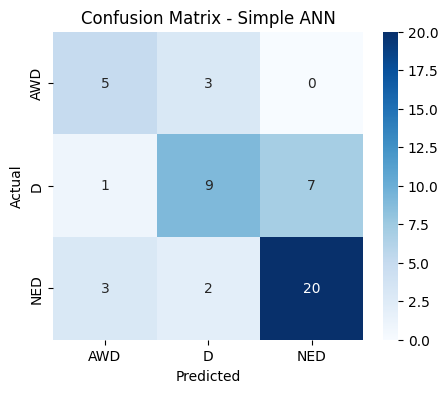


Deep ANN Model Classification Report:

              precision    recall  f1-score   support

         AWD       0.56      0.62      0.59         8
           D       0.67      0.59      0.62        17
         NED       0.73      0.76      0.75        25

    accuracy                           0.68        50
   macro avg       0.65      0.66      0.65        50
weighted avg       0.68      0.68      0.68        50



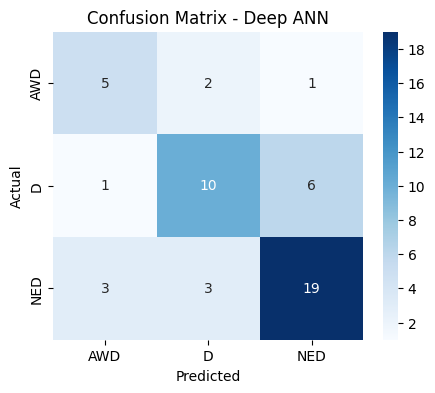


CNN Model Classification Report:

              precision    recall  f1-score   support

         AWD       0.29      0.50      0.36         8
           D       0.80      0.24      0.36        17
         NED       0.61      0.76      0.68        25

    accuracy                           0.54        50
   macro avg       0.57      0.50      0.47        50
weighted avg       0.62      0.54      0.52        50



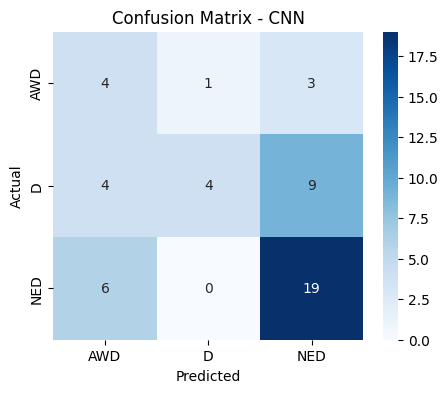


LSTM Model Classification Report:

              precision    recall  f1-score   support

         AWD       0.71      0.62      0.67         8
           D       0.65      0.65      0.65        17
         NED       0.81      0.84      0.82        25

    accuracy                           0.74        50
   macro avg       0.72      0.70      0.71        50
weighted avg       0.74      0.74      0.74        50



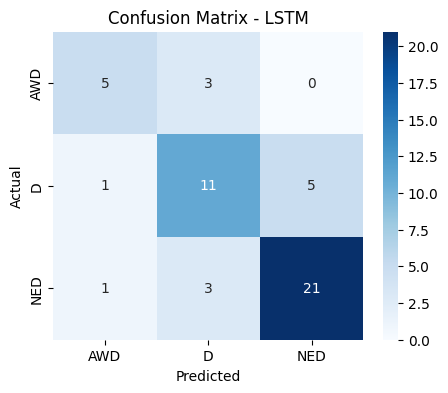

In [69]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot for each model
for name, preds in predictions.items():
    print(f"\n{name} Model Classification Report:\n")
    print(classification_report(y_test, preds, target_names=label_encoder.classes_))
    plot_confusion(y_test, preds, name)